<a href="https://colab.research.google.com/github/Bhaveshsisodia/lstm_demand_forecasting/blob/main/LSTM_univariate_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Dropout

In [149]:
df = pd.read_csv("/content/drive/MyDrive/data_lstm.csv")
df.head()

,city_id,date_int,time_block,hour,iconcode,precipitation,pressurechange,pressuremeansealevel,relativehumidity,temperature,...,visibility,winddirection,windgust,windspeed,demand,month,year,day_of_week,day_of_year,day_of_month
0,7,20240101,24,6,20.0,0.0,0.30,1017.90,93.70,9.70,...,0.13,40.0,0.0,2.50,1638.00,1,2024,0,1,1
1,7,20240101,25,7,20.0,0.0,0.45,1018.18,91.25,9.57,...,0.35,37.5,0.0,3.32,1731.75,1,2024,0,1,1
2,7,20240101,26,7,20.0,0.0,0.60,1018.45,88.80,9.45,...,0.56,35.0,0.0,4.15,1832.87,1,2024,0,1,1
3,7,20240101,27,7,20.0,0.0,0.75,1018.72,86.35,9.32,...,0.78,32.5,0.0,4.97,1932.22,1,2024,0,1,1
4,7,20240101,28,7,20.0,0.0,0.90,1019.00,83.90,9.20,...,1.00,30.0,0.0,5.80,2021.00,1,2024,0,1,1


In [150]:
df['Date'] =pd.to_datetime(df['date_int'],format="%Y%m%d")

In [151]:
max(df['date_int']), min(df['date_int'])

(20250502, 20240101)

In [152]:
train_df = df[(df['date_int'] >= 20240101) & (df['date_int'] <= 20250131)]
test_df = df[(df['date_int'] >= 20250201) & (df['date_int'] <= 20250228)]

In [153]:
model_data = train_df[train_df['city_id']==7]
model_data_test = test_df[test_df['city_id']==7]

In [154]:
model_data=model_data[['date_int','time_block','demand']]
model_data_test=model_data_test[['date_int','time_block','demand']]

In [155]:
# Combine date and block number to datetime (15-min intervals)
model_data['Datetime'] = pd.to_datetime(model_data['date_int'],format="%Y%m%d") + pd.to_timedelta((model_data['time_block'] - 1) * 15, unit='m')


model_data_test['Datetime'] = pd.to_datetime(model_data_test['date_int'],format="%Y%m%d") + pd.to_timedelta((model_data_test['time_block'] - 1) * 15, unit='m')

In [156]:
model_data_test

,date_int,time_block,demand,Datetime
257123,20250201,1,1559.60,2025-02-01 00:00:00
257124,20250201,2,1547.02,2025-02-01 00:15:00
257125,20250201,3,1537.43,2025-02-01 00:30:00
257126,20250201,4,1528.00,2025-02-01 00:45:00
257127,20250201,5,1518.23,2025-02-01 01:00:00
...,...,...,...,...
275358,20250228,92,1453.00,2025-02-28 22:45:00
275359,20250228,93,1429.03,2025-02-28 23:00:00
275360,20250228,94,1405.78,2025-02-28 23:15:00
275361,20250228,95,1384.74,2025-02-28 23:30:00


In [157]:
model_data = model_data[['Datetime', 'demand']]
model_data.set_index('Datetime', inplace=True)

In [158]:
model_data_test = model_data_test[['Datetime', 'demand']]
model_data_test.set_index('Datetime', inplace=True)

In [159]:
model_data

,demand
Datetime,
2024-01-01 05:45:00,1638.00
2024-01-01 06:00:00,1731.75
2024-01-01 06:15:00,1832.87
2024-01-01 06:30:00,1932.22
2024-01-01 06:45:00,2021.00
...,...
2025-01-31 22:45:00,1710.00
2025-01-31 23:00:00,1669.07
2025-01-31 23:15:00,1633.14


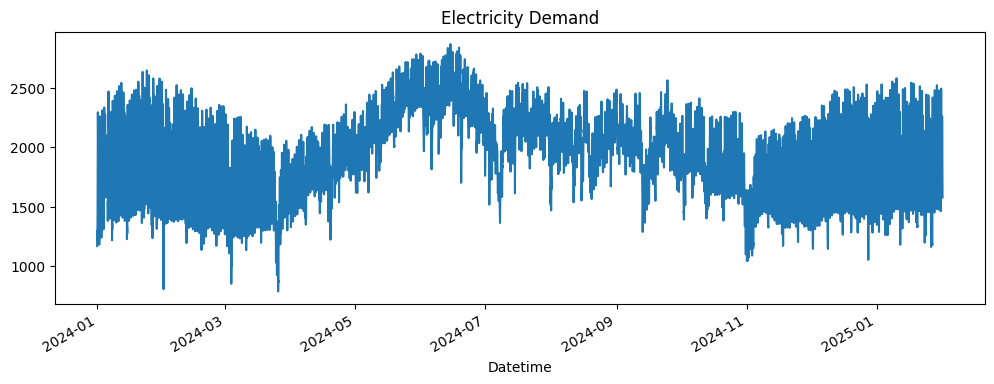

In [160]:
model_data = model_data.sort_index()

# Plot the demand
model_data['demand'].plot(figsize=(12, 4), title='Electricity Demand')
plt.show()

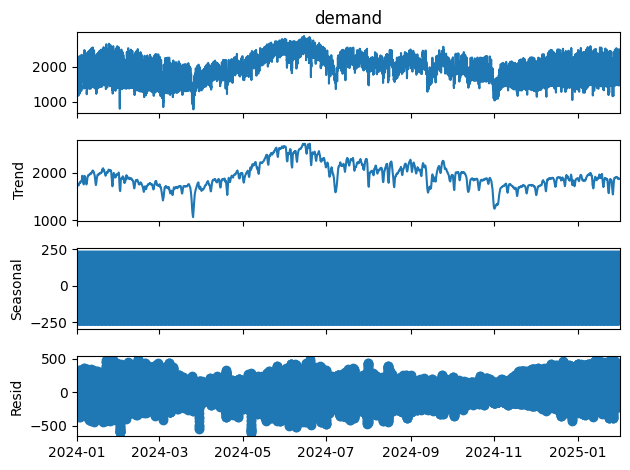

In [161]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(model_data['demand'], model='additive', period=96)  # 96 blocks per day
result.plot()
plt.show()


In [162]:
model_data

,demand
Datetime,
2024-01-01 00:00:00,1169.10
2024-01-01 00:15:00,1234.42
2024-01-01 00:30:00,1277.33
2024-01-01 00:45:00,1299.00
2024-01-01 01:00:00,1296.92
...,...
2025-01-31 22:45:00,1710.00
2025-01-31 23:00:00,1669.07
2025-01-31 23:15:00,1633.14


In [163]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(model_data)

In [164]:
test_scaled = scaler.transform(model_data_test)



In [165]:
train_scaled

array([[0.18305173],
       [0.2144595 ],
       [0.23509189],
       ...,
       [0.40617577],
       [0.39152009],
       [0.37966284]])

In [166]:
# Function to create input-output sequences
def create_sequences(data, window_size=96):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Window size = 1 day = 96 blocks
window_size = 96
X_train, y_train = create_sequences(train_scaled, window_size)

X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [167]:
X_train

array([[[0.18305173],
        [0.2144595 ],
        [0.23509189],
        ...,
        [0.32358372],
        [0.31179859],
        [0.29984517]],

       [[0.2144595 ],
        [0.23509189],
        [0.24551146],
        ...,
        [0.31179859],
        [0.29984517],
        [0.18867743]],

       [[0.23509189],
        [0.24551146],
        [0.24451133],
        ...,
        [0.29984517],
        [0.18867743],
        [0.2188062 ]],

       ...,

       [[0.41713868],
        [0.40350717],
        [0.39072192],
        ...,
        [0.46509179],
        [0.44313231],
        [0.42345197]],

       [[0.40350717],
        [0.39072192],
        [0.37857617],
        ...,
        [0.44313231],
        [0.42345197],
        [0.40617577]],

       [[0.39072192],
        [0.37857617],
        [0.36727187],
        ...,
        [0.42345197],
        [0.40617577],
        [0.39152009]]])

In [168]:
# model = Sequential([
#     Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.3),
#     Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))),
#     Dropout(0.3),
#     Dense(16, activation='relu'),
#     Dense(1)
# ])

In [169]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



535/535 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.1606 - val_loss: 0.0032
Epoch 2/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 3/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0016 - val_loss: 7.8390e-04
Epoch 4/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0011 - val_loss: 9.6749e-04
Epoch 5/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0010 - val_loss: 7.7767e-04
Epoch 6/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 9.6398e-04 - val_loss: 4.8988e-04
Epoch 7/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 8.5195e-04 - val_loss: 4.9628e-04
Epoch 8/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 8.3072e-04 - val_loss: 4.5268e-04
Epoch 9/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 7.6230e-04 - val_loss: 7.1774e-04
Epoch 10/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 7.2229e-04 - val_loss: 4.4523e-04
Epoch 11/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 6.289

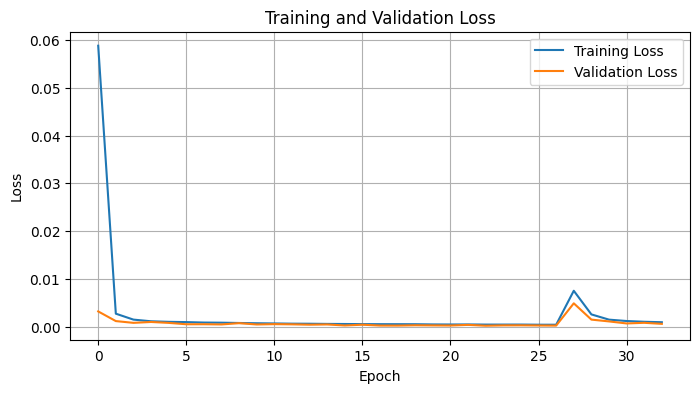

In [170]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [171]:
# Predict
predicted_scaled = model.predict(X_test)

# Inverse transform
predicted = scaler.inverse_transform(predicted_scaled)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
len(y_test_true)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


2592

In [172]:
len(predicted)

2592

In [173]:
df_test =pd.concat([pd.DataFrame(y_test_true,columns=['Actual']), pd.DataFrame(predicted,columns=['Predicted'])],axis=1)

<Axes: >

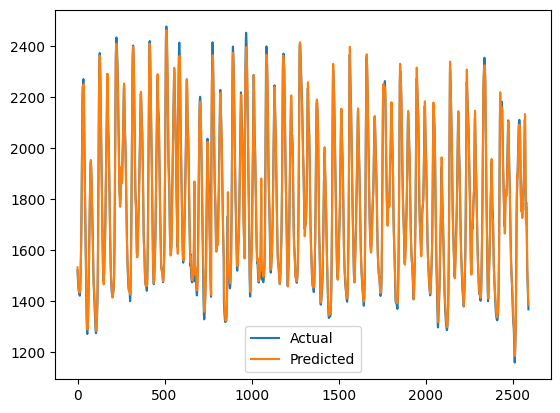

In [174]:
df_test[:].plot()

In [175]:
model_data_test

,demand
Datetime,
2025-02-01 00:00:00,1559.60
2025-02-01 00:15:00,1547.02
2025-02-01 00:30:00,1537.43
2025-02-01 00:45:00,1528.00
2025-02-01 01:00:00,1518.23
...,...
2025-02-28 22:45:00,1453.00
2025-02-28 23:00:00,1429.03
2025-02-28 23:15:00,1405.78


In [176]:
df_final=pd.concat([model_data_test[96:].reset_index(),pd.DataFrame(predicted,columns=['Predicted'])],axis=1)

In [177]:
df_final

,Datetime,demand,Predicted
0,2025-02-02 00:00:00,1521.06,1532.519897
1,2025-02-02 00:15:00,1501.85,1514.020508
2,2025-02-02 00:30:00,1486.76,1499.053467
3,2025-02-02 00:45:00,1474.00,1486.420044
4,2025-02-02 01:00:00,1463.06,1474.765625
...,...,...,...
2587,2025-02-28 22:45:00,1453.00,1468.271606
2588,2025-02-28 23:00:00,1429.03,1452.078125
2589,2025-02-28 23:15:00,1405.78,1431.983643
2590,2025-02-28 23:30:00,1384.74,1409.055054


In [178]:
def daily_mape(group):
    return np.mean(np.abs((group['demand'] - group['Predicted']) / group['demand'])) * 100

# Compute daily MAPE
daily_mape_values = df_final.groupby('Datetime').apply(daily_mape)

<ipython-input-178-1b5e0cc03b29>:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



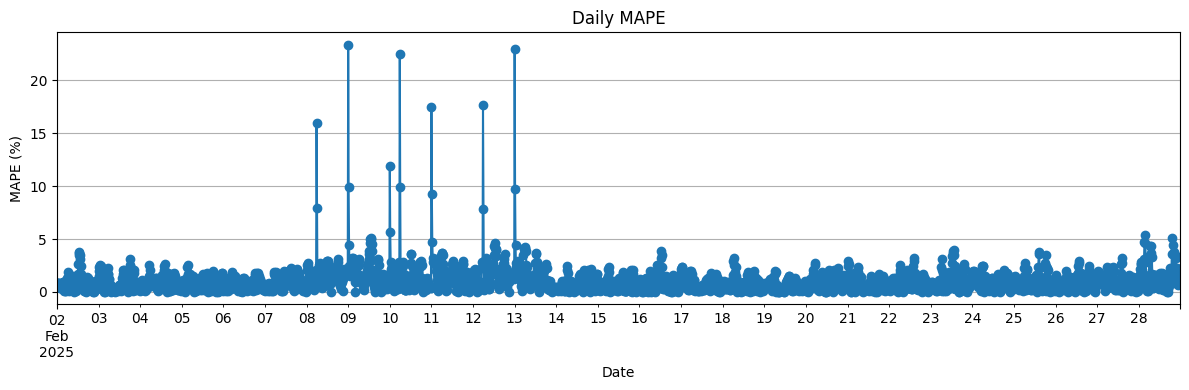

Average MAPE for February: 1.10%


In [179]:

# Plot daily MAPE
plt.figure(figsize=(12, 4))
daily_mape_values.plot(marker='o')
plt.title("Daily MAPE")
plt.ylabel("MAPE (%)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print average MAPE over the month
print(f"Average MAPE for February: {daily_mape_values.mean():.2f}%")

In [180]:
daily_mape_values=daily_mape_values.reset_index()

In [181]:
daily_mape_values['Date'] = daily_mape_values['Datetime'].dt.date
daily_mape_values['Time'] = daily_mape_values['Datetime'].dt.time

# Reorder columns (optional)
daily_mape_values = daily_mape_values[['Datetime', 'Date', 'Time', 0]]

In [182]:
daily_mape_values[['Date',0]].groupby(['Date']).mean()

,0
Date,
2025-02-02,0.789691
2025-02-03,0.912014
2025-02-04,0.884587
2025-02-05,0.796912
2025-02-06,0.733594
2025-02-07,0.865171
2025-02-08,1.770122
2025-02-09,2.038161
2025-02-10,1.742080


In [183]:
df_final

,Datetime,demand,Predicted
0,2025-02-02 00:00:00,1521.06,1532.519897
1,2025-02-02 00:15:00,1501.85,1514.020508
2,2025-02-02 00:30:00,1486.76,1499.053467
3,2025-02-02 00:45:00,1474.00,1486.420044
4,2025-02-02 01:00:00,1463.06,1474.765625
...,...,...,...
2587,2025-02-28 22:45:00,1453.00,1468.271606
2588,2025-02-28 23:00:00,1429.03,1452.078125
2589,2025-02-28 23:15:00,1405.78,1431.983643
2590,2025-02-28 23:30:00,1384.74,1409.055054


In [184]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_percentage_error

In [185]:
df_final['Date'] = df_final['Datetime'].dt.date
df_final['Time'] = df_final['Datetime'].dt.time

In [186]:
df_final['date'] = df_final['Date'].astype(str)

# Optional: create 15-minute block numbers in a day (0–95)
df_final['time_block'] = df_final['Datetime'].dt.hour * 4 + df_final['Datetime'].dt.minute // 15

# Filter February data only
feb_df = df_final[df_final['Datetime'].dt.month == 2]

# Get unique sorted February dates
feb_dates = sorted(feb_df['date'].unique())
num_days = len(feb_dates)

In [187]:
titles = []
daily_dfs = []

for date in feb_dates:
    daily_data = feb_df[feb_df['date'] == date]

    # ⬇️ Aggregate by time_block (average)
    daily_avg = daily_data.groupby('time_block')[['demand', 'Predicted']].mean().reset_index()
    daily_dfs.append(daily_avg)

    # Calculate MAPE after aggregation
    mape = mean_absolute_percentage_error(daily_avg['demand'], daily_avg['Predicted']) * 100
    titles.append(f"{date} (MAPE: {mape:.2f}%)")

# Subplot grid size
cols = 4
rows = (num_days + cols - 1) // cols

fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles)

# Add traces for each day's data
for idx, daily_df in enumerate(daily_dfs):
    row = (idx // cols) + 1
    col = (idx % cols) + 1

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['demand'],
        mode='lines',
        name='demand',
        line=dict(color='blue'),
        showlegend=(idx == 0)
    ), row=row, col=col)

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['Predicted'],
        mode='lines',
        name='Predicted',
        line=dict(color='red'),
        showlegend=(idx == 0)
    ), row=row, col=col)

# Update layout
fig.update_layout(
    height=300 * rows,
    width=1200,
    title_text="February Daily Predictions (Actual vs Predicted with MAPE)",
    legend=dict(x=1.02, y=1),
    margin=dict(t=80)
)

fig.show()


In [188]:
full_demand_series = model_data['demand'].values.reshape(-1, 1)

# Scale it
demand_scaler = MinMaxScaler()
scaled_demand = demand_scaler.fit_transform(full_demand_series)

In [189]:
window_size = 96
n_forecast_steps = 5 * 96  # 31 days × 96 blocks/day

# Start with last `window_size` points from Feb
input_seq = scaled_demand[-window_size:].reshape(1, window_size, 1)

predictions_scaled = []

for _ in range(n_forecast_steps):
    pred = model.predict(input_seq)[0][0]  # single step prediction
    predictions_scaled.append(pred)

    # Append prediction and move window
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━

In [190]:
# Convert list to array
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)

# Inverse transform
predictions = demand_scaler.inverse_transform(predictions_scaled)

In [191]:
import pandas as pd

# Generate timestamp range for March
start_time = pd.to_datetime('2025-02-01')
datetime_index = pd.date_range(start=start_time, periods=n_forecast_steps, freq='15min')

# Combine into a DataFrame
feb_forecast = pd.DataFrame({
    'Datetime': datetime_index,
    'Predicted_Demand': predictions.ravel()
})

In [192]:
feb_forecast

,Datetime,Predicted_Demand
0,2025-02-01 00:00:00,1556.588501
1,2025-02-01 00:15:00,1543.038208
2,2025-02-01 00:30:00,1532.783447
3,2025-02-01 00:45:00,1524.388794
4,2025-02-01 01:00:00,1516.608276
...,...,...
475,2025-02-05 22:45:00,1546.594727
476,2025-02-05 23:00:00,1545.855347
477,2025-02-05 23:15:00,1545.729370
478,2025-02-05 23:30:00,1546.146362


In [193]:
df_lstm=pd.merge(feb_forecast, df_final[['Datetime','demand','Date','time_block']], on='Datetime', how='left').dropna()

In [194]:
df_lstm

,Datetime,Predicted_Demand,demand,Date,time_block
96,2025-02-02 00:00:00,1515.600952,1521.06,2025-02-02,0.0
97,2025-02-02 00:15:00,1509.451538,1501.85,2025-02-02,1.0
98,2025-02-02 00:30:00,1506.036133,1486.76,2025-02-02,2.0
99,2025-02-02 00:45:00,1504.364014,1474.00,2025-02-02,3.0
100,2025-02-02 01:00:00,1503.595093,1463.06,2025-02-02,4.0
...,...,...,...,...,...
475,2025-02-05 22:45:00,1546.594727,1702.00,2025-02-05,91.0
476,2025-02-05 23:00:00,1545.855347,1670.57,2025-02-05,92.0
477,2025-02-05 23:15:00,1545.729370,1652.35,2025-02-05,93.0
478,2025-02-05 23:30:00,1546.146362,1638.49,2025-02-05,94.0


In [195]:
titles = []
daily_dfs = []

# Get unique sorted February dates
feb_dates = sorted(df_lstm['Date'].unique())
num_days = len(feb_dates)
for date in feb_dates:
    daily_data = df_lstm[df_lstm['Date'] == date]

    # ⬇️ Aggregate by time_block (average)
    daily_avg = daily_data.groupby('time_block')[['demand', 'Predicted_Demand']].mean().reset_index()
    daily_dfs.append(daily_avg)
    # print(daily_dfs)

    # Calculate MAPE after aggregation
    mape = mean_absolute_percentage_error(daily_avg['demand'], daily_avg['Predicted_Demand']) * 100
    titles.append(f"{date} (MAPE: {mape:.2f}%)")

# Subplot grid size
cols = 4
rows = (num_days + cols - 1) // cols

fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles)

# Add traces for each day's data
for idx, daily_df in enumerate(daily_dfs):
    row = (idx // cols) + 1
    col = (idx % cols) + 1

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['demand'],
        mode='lines',
        name='demand',
        line=dict(color='blue'),
        showlegend=(idx == 0)
    ), row=row, col=col)

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['Predicted_Demand'],
        mode='lines',
        name='Predicted',
        line=dict(color='red'),
        showlegend=(idx == 0)
    ), row=row, col=col)

# Update layout
fig.update_layout(
    height=300 * rows,
    width=1200,
    title_text="February Daily Predictions (Actual vs Predicted with MAPE)",
    legend=dict(x=1.02, y=1),
    margin=dict(t=80)
)

fig.show()
